# European Grid TD-OPF Simulation Visualisation

This notebook visualises Temperature-Dependent Optimal Power Flow
(TD-OPF) results for single-country European grid models under
projected heatwave scenarios.

**Contents**
1. Configuration
2. Heatwave scenario overview
3. Model baseline comparison (AC-OPF vs Quad / Iter / TD-OPF)
4. Model ablation analysis
5. Thermal-limit sensitivity analysis
6. Temporal analysis (yearly 2026–2030 and intra-day 12–15 h)
7. Load-growth and storage sensitivity
8. Exploratory scatter plots (temperature vs load shedding)

## 1. Imports

In [43]:
import os
import sys
from datetime import datetime

cur_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(os.getcwd(), ".."))

from data_config import *
from utils.network_process_utils import *
from utils.plot_utils import *

## 2. Configuration

In [44]:
country_code = ['ES', 'FR', 'IT', 'PT', 'NL', 'BE', 'GB', 'DE'][0]
n_bus = country_bus[country_code]
os.makedirs(os.path.join(cur_dir, f'models/{country_code}/pics'), exist_ok=True)

load_rate = 1.01
storage_state = 0.8
thermal_limit = 90

## 3. Helper Utilities

Convenience functions to avoid repeating the long CSV path template and
the valid-index filtering logic across every section.

In [45]:
def build_csv_path(country_code, n_bus, storage, load_rate, max_temp,
                   suffix='model_analysis'):
    """Build the standard experiment CSV path."""
    return (
        cur_dir
        + f'/models/{country_code}/{country_code}_{n_bus}_bus'
        + f'_renewable_True_heatwave_True_storage_True_{storage}'
        + f'_load_growth_True_{load_rate}_max_temp_{max_temp}'
        + f'_{suffix}.csv'
    )


def build_result_id(country_code, n_bus, solver, fut_date, his_date,
                    storage, load_rate, thermal):
    """Build the .npy result filename from experiment parameters."""
    base_id = f'{country_code}_{n_bus}_{solver}_{fut_date}_{his_date}'
    para_id = f'storage_{storage}_load_growth_{load_rate}_thermal_{thermal}'
    return f'{base_id}_{para_id}_results.npy'


def get_valid_index(df, solver_list):
    """Return a boolean mask where *all* solvers succeeded."""
    masks = []
    for solver in solver_list:
        sub = df[df['TDPF_solver'] == solver]
        masks.append((sub['solver_status'] == 1).values)
    return np.logical_and.reduce(np.stack(masks, axis=0), axis=0)


def load_branch_results(df, solver, valid_index, country_code, n_bus,
                        storage_state, load_rate, thermal_limit):
    """Load per-branch con_temp and capacity_drop for all valid scenarios."""
    temp_list, capa_list = [], []
    sub_df = df[df['TDPF_solver'] == solver]
    for fut_date in sub_df.loc[valid_index, 'fut_heatwave_date'].unique():
        sub2 = sub_df[sub_df['fut_heatwave_date'] == fut_date]
        ppc_path = cur_dir + f'/models/{country_code}/ppc/{fut_date}'
        for his_date in sub2['his_heatwave_date'].unique():
            dt_obj = datetime.strptime(his_date, '%Y-%m-%d')
            his_date_fmt = dt_obj.strftime('%Y-%m-%d %H:%M:%S')
            fname = build_result_id(
                country_code, n_bus, solver, fut_date, his_date_fmt,
                storage_state, load_rate, thermal_limit,
            )
            results = np.load(
                os.path.join(ppc_path, fname), allow_pickle=True
            ).item()
            temp_list.append(results['con_temp'].max(1))
            capa_list.append(results['capacity_drop'])
    temp_arr = np.concatenate(temp_list).reshape(-1)
    capa_arr = np.concatenate(capa_list).reshape(-1) * 100
    return temp_arr, capa_arr

## 4. Heatwave Scenario Overview

In [46]:
df_path = build_csv_path(country_code, n_bus, storage_state,
                        load_rate, thermal_limit)
df = pd.read_csv(df_path)

for fut_year in range(2026, 2031):
    sub = df[(df['fut_heatwave_year'] == fut_year)
             & (df['TDPF_solver'] == 'base')]
    temp = sub['air_temp'].values
    wind = sub['wind_speed'].values
    solar = sub['solar_radia'].values
    load = sub['load'].values
    print(
        f'Year {fut_year}  '
        f'mean temp {temp.mean():.2f}  wind {wind.mean():.2f}  '
        f'solar {solar.mean():.2f}  load {load.mean():.2f} | '
        f'std temp {temp.std():.2f}  wind {wind.std():.2f}  '
        f'solar {solar.std():.2f}  load {load.std():.2f}'
    )

Year 2026  mean temp 36.05  wind 2.27  solar 785.52  load 36.47 | std temp 2.59  wind 0.37  solar 67.23  load 1.45
Year 2027  mean temp 36.92  wind 2.87  solar 753.82  load 37.48 | std temp 2.58  wind 0.36  solar 70.45  load 1.33
Year 2028  mean temp 36.93  wind 2.65  solar 717.83  load 37.98 | std temp 3.46  wind 0.40  solar 91.25  load 2.12
Year 2029  mean temp 37.52  wind 2.62  solar 789.08  load 38.23 | std temp 2.58  wind 0.43  solar 66.75  load 1.36
Year 2030  mean temp 37.58  wind 2.69  solar 766.68  load 38.71 | std temp 2.58  wind 0.35  solar 62.69  load 1.62


## 5. Model Baseline Comparison

Compare AC-OPF, Quad-OPF, Iter-OPF, and TD-OPF on load shedding,
running time, line temperature, and capacity drop.

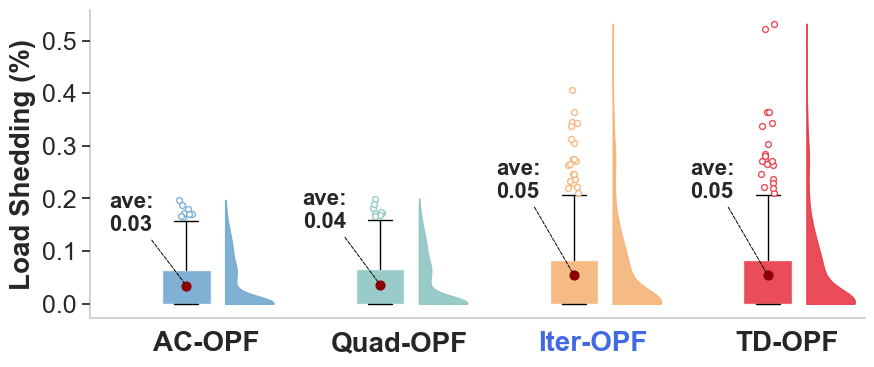

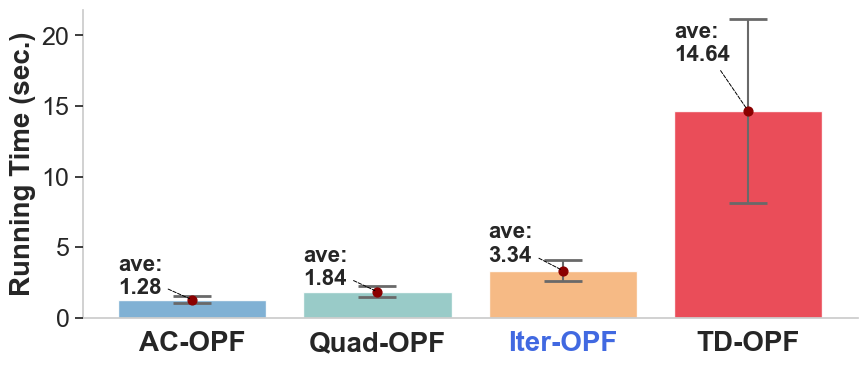

In [47]:
df_path = build_csv_path(country_code, n_bus, storage_state,
                        load_rate, thermal_limit)
df = pd.read_csv(df_path)
colors = [colors_list[key] for key in analysis_list]
valid_index = get_valid_index(df, analysis_list)

analysis_list = [
    'base',
    'td_quad',
    'td_seg_derate_iter_2',
    'td_seg_derate_iter_10',
]

# --- Load shedding and runtime per solver --------------------------------
data_load_shedding_list = []
data_run_time_list = []
for solver in analysis_list:
    sub = df[df['TDPF_solver'] == solver]
    # valid_index = (sub['solver_status'] == 1)
    data_load_shedding_list.append(
        sub.loc[valid_index, 'node_load_shedding'].values.reshape(-1)
    )
    data_run_time_list.append(
        sub.loc[valid_index, 'run_time'].values.reshape(-1)
    )

box_violin_plot(
    data_load_shedding_list, model_list, colors, 'Load Shedding (%)',
    os.path.join(cur_dir, f'models/{country_code}/pics/model_load_shedding_box_violin.pdf'),
)
single_bar_plot(
    data_run_time_list, model_list, colors, 'Running Time (sec.)',
    os.path.join(cur_dir, f'models/{country_code}/pics/model_running_time.pdf'),
    text_above=False,
)

In [48]:
# print load shedding error
ls_error = np.abs(data_load_shedding_list[-2] - data_load_shedding_list[-1])
print(f'Iter-OPF: {data_load_shedding_list[-1].mean()}, TD-OPF: {data_load_shedding_list[-2].mean()}')
print(f'load shedding error between Iter-OPF and TD-OPF: {ls_error.mean()}')

Iter-OPF: 0.05476922603025902, TD-OPF: 0.05477107566885375
load shedding error between Iter-OPF and TD-OPF: 2.276229301685353e-06


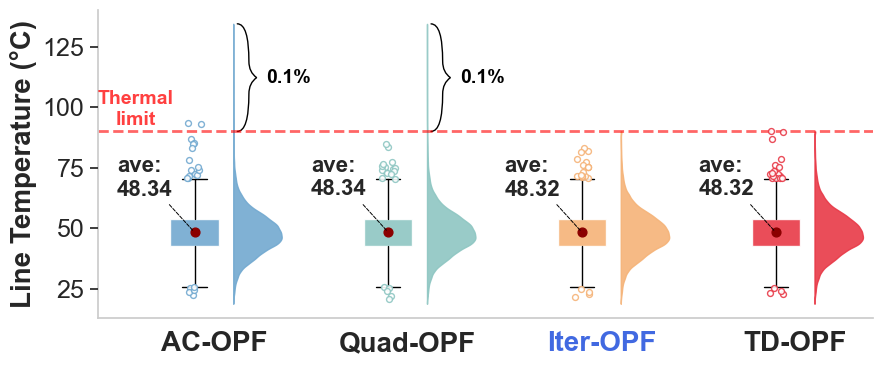

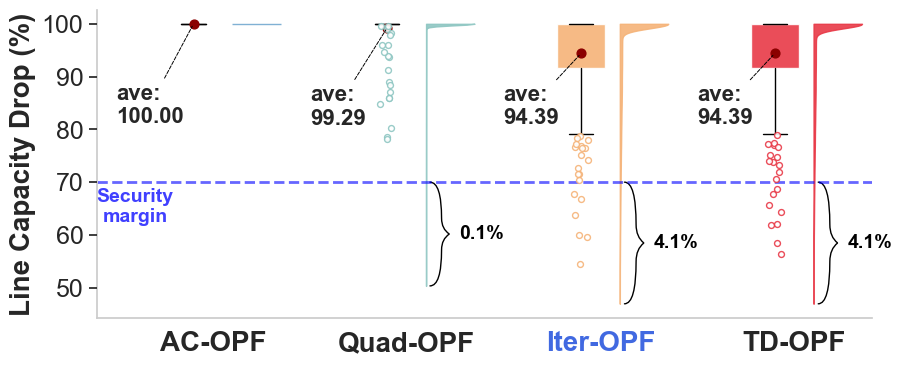

In [49]:
# --- Line temperature and capacity drop per solver -----------------------
data_temp_list = []
data_capa_list = []
for solver in analysis_list:
    temp_arr, capa_arr = load_branch_results(
        df, solver, valid_index, country_code, n_bus,
        storage_state, load_rate, thermal_limit,
    )
    data_temp_list.append(temp_arr)
    data_capa_list.append(capa_arr)

box_violin_plot(
    data_temp_list, model_list, colors, 'Line Temperature (°C)',
    os.path.join(cur_dir, f'models/{country_code}/pics/model_line_temp_box_violin.pdf'),    
    threshold=90,
    exceed_direction='above',
)
box_violin_plot(
    data_capa_list, model_list, colors, 'Line Capacity Drop (%)',
    os.path.join(cur_dir, f'models/{country_code}/pics/model_capacity_drop_box_violin.pdf'),
    threshold=70,
    exceed_direction='below',
)

In [50]:
# print line temperature error
temp_error = np.abs(data_temp_list[-2] - data_temp_list[-1])
print(f'Iter-OPF: {data_temp_list[-1].mean()}, TD-OPF: {data_temp_list[-2].mean()}')
print(f'line temperature error between Iter-OPF and TD-OPF: {temp_error.mean()}')

Iter-OPF: 48.32162946838526, TD-OPF: 48.32075726296951
line temperature error between Iter-OPF and TD-OPF: 0.026584901250736464


## 6. Model Ablation Analysis

Ablation study: Iter-OPF vs variants that remove thermal constraints,
segmented modelling, generator derating, or add security constraints.

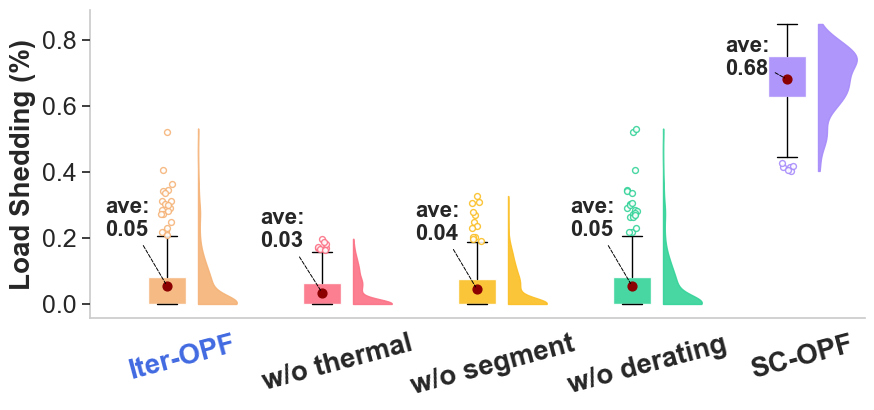

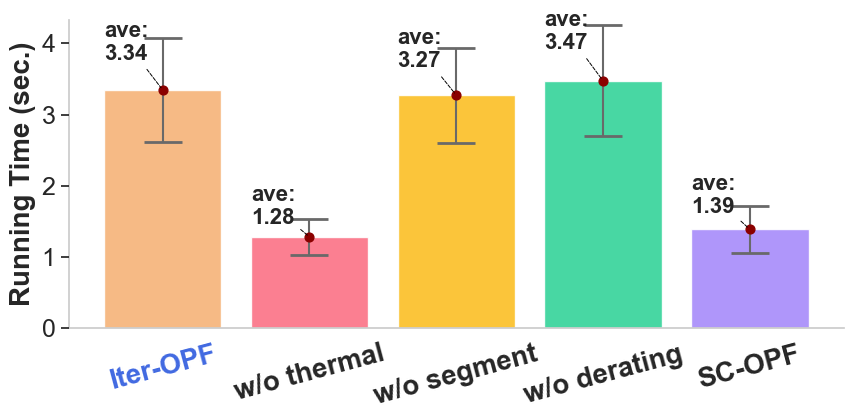

In [51]:
df = pd.read_csv(build_csv_path(
    country_code, n_bus, storage_state, load_rate, thermal_limit,
))
solvers = sensitivity_analysis_list
models = sensitivity_model_list
colors = [colors_list[key] for key in solvers]
valid_index = get_valid_index(df, solvers)

# --- Load shedding and runtime -------------------------------------------
data_load_shedding_list = []
data_run_time_list = []
for solver in solvers:
    sub = df[df['TDPF_solver'] == solver]
    data_load_shedding_list.append(
        sub.loc[valid_index, 'node_load_shedding'].values.reshape(-1)
    )
    data_run_time_list.append(
        sub.loc[valid_index, 'run_time'].values.reshape(-1)
    )

box_violin_plot(
    data_load_shedding_list, models, colors, 'Load Shedding (%)',
    os.path.join(cur_dir, f'models/{country_code}/pics/sensitivity_model_load_shedding_box_violin.pdf'),
    label_rotation=15,
)
single_bar_plot(
    data_run_time_list, models, colors, 'Running Time (sec.)',
    os.path.join(cur_dir, f'models/{country_code}/pics/sensitivity_model_running_time.pdf'),
    label_rotation=15, text_above=False,
)

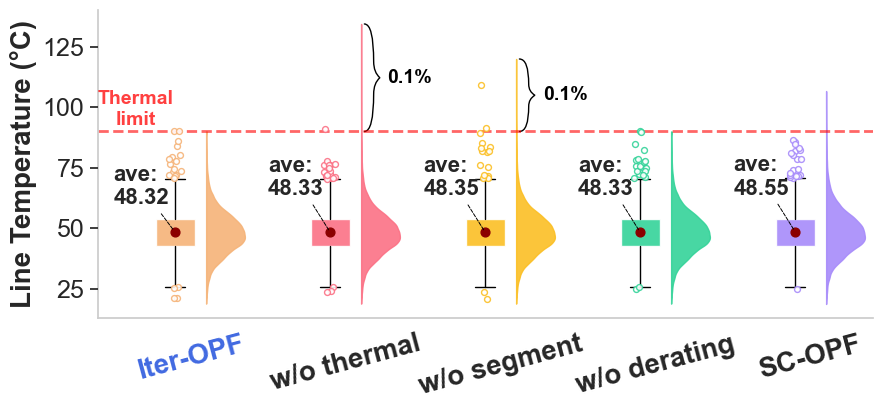

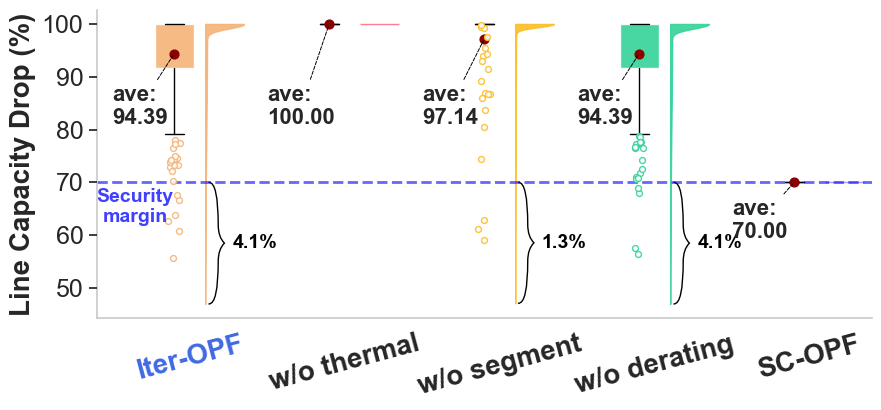

In [52]:
# --- Line temperature and capacity drop -----------------------------------
data_temp_list = []
data_drop_list = []
for solver in solvers:
    temp_arr, capa_arr = load_branch_results(
        df, solver, valid_index, country_code, n_bus,
        storage_state, load_rate, thermal_limit,
    )
    data_temp_list.append(temp_arr)
    data_drop_list.append(capa_arr)

box_violin_plot(
    data_temp_list, models, colors, 'Line Temperature (°C)',
    os.path.join(cur_dir, f'models/{country_code}/pics/sensitivity_model_line_temp_box_violin.pdf'),
    label_rotation=15, threshold=90, exceed_direction='above',
)
box_violin_plot(
    data_drop_list, models, colors, 'Line Capacity Drop (%)',
    os.path.join(cur_dir, f'models/{country_code}/pics/sensitivity_model_capacity_drop_box_violin.pdf'),
    label_rotation=15, threshold=70, exceed_direction='below',
)

## 7. Thermal-Limit Sensitivity Analysis

Compare load shedding across different maximum conductor temperature
ratings (individual 90 °C, corrected 90 / 120 / 150 / 180 °C).

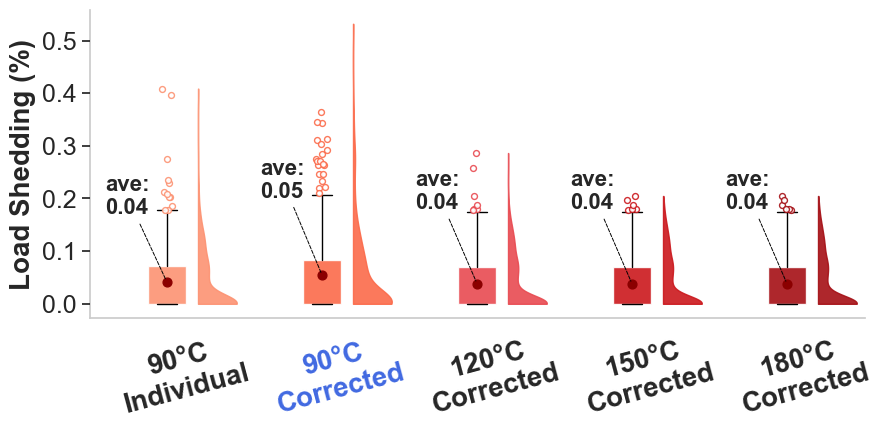

In [53]:
thermal_list = ['single', 90, 120, 150, 180]
scenario_labels = [
    '90°C\nIndividual', '90°C\nCorrected', '120°C\nCorrected',
    '150°C\nCorrected', '180°C\nCorrected',
]

data_list = []
for max_temp in thermal_list:
    if max_temp == 90:
        csv = build_csv_path(country_code, n_bus, storage_state,
                             load_rate, thermal_limit)
        solvers_t = ['td_seg_derate_iter_2']
    elif max_temp == 'single':
        csv = build_csv_path(country_code, n_bus, storage_state,
                             1.01, thermal_limit)
        solvers_t = ['td_sin_seg_derate_iter_2']
    else:
        csv = build_csv_path(country_code, n_bus, storage_state,
                             1.01, max_temp,
                             suffix='thermal_analysis')
        solvers_t = ['td_seg_derate_iter_2']

    df_t = pd.read_csv(csv)
    vi = get_valid_index(df_t, solvers_t)
    for solver in solvers_t:
        sub = df_t[df_t['TDPF_solver'] == solver]
        data_list.append(
            sub.loc[vi, 'node_load_shedding'].values.reshape(-1)
        )

box_violin_plot(
    data_list, scenario_labels, colors_red, 'Load Shedding (%)',
    os.path.join(cur_dir, f'models/{country_code}/pics/thermal_load_shedding_box_violin.pdf'),
    label_rotation=15,
)

## 8. Temporal Analysis — Yearly (2026–2030)

How do load shedding, line temperature, and capacity drop evolve across
projected heatwave years?

In [54]:
df = pd.read_csv(build_csv_path(
    country_code, n_bus, storage_state, load_rate, thermal_limit,
))
fut_year_list = list(range(2026, 2031))
TDPF_solver = 'td_seg_derate_iter_2'

# Valid index across all years
valid_index = get_valid_index(
    df[df['TDPF_solver'] == TDPF_solver].assign(
        TDPF_solver=lambda d: d['fut_heatwave_year'].astype(str)
    ).rename(columns={'TDPF_solver': 'TDPF_solver'}),
    [str(y) for y in fut_year_list],
) if False else None  # use per-year approach below

# Per-year valid index (intersected)
vi_list = []
for yr in fut_year_list:
    sub = df[(df['TDPF_solver'] == TDPF_solver)
             & (df['fut_heatwave_year'] == yr)]
    vi_list.append((sub['solver_status'] == 1).values)
valid_index = np.logical_and.reduce(vi_list)

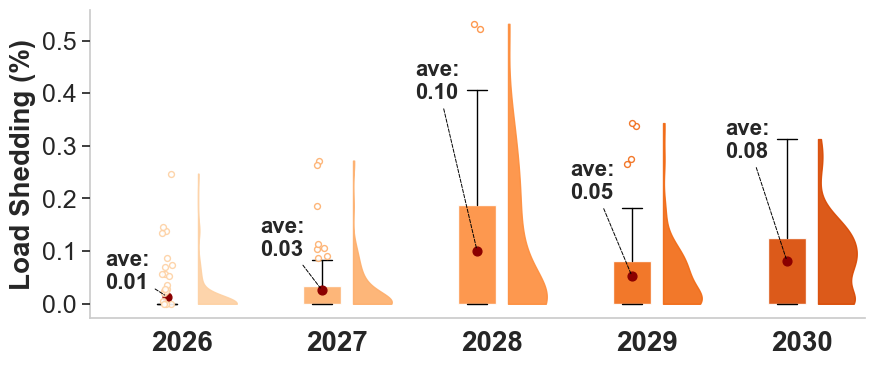

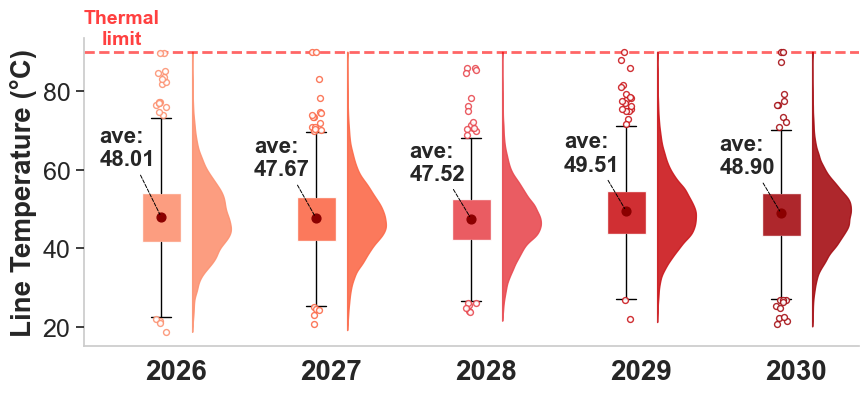

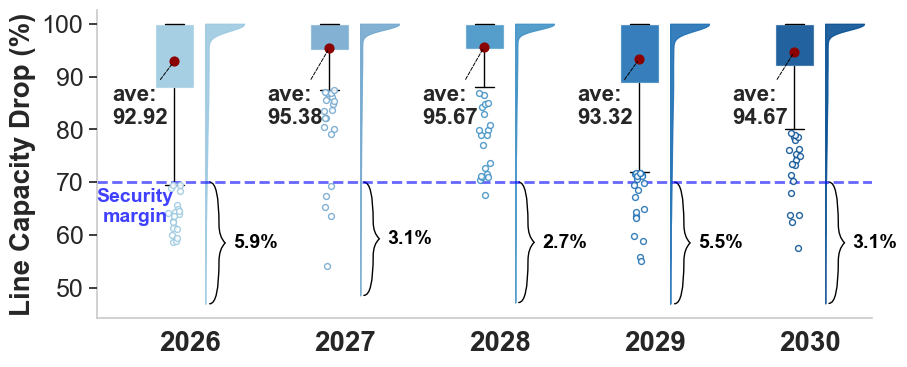

In [55]:
# --- Load shedding per year ------------------------------------------------
ls_list = []
for yr in fut_year_list:
    sub = df[(df['TDPF_solver'] == TDPF_solver)
             & (df['fut_heatwave_year'] == yr)]
    ls_list.append(sub.loc[valid_index, 'node_load_shedding'].values.reshape(-1))

box_violin_plot(
    ls_list, fut_year_list, colors_orange, 'Load Shedding (%)',
    os.path.join(cur_dir, f'models/{country_code}/pics/temporal_load_shedding_box_violin.pdf'),
)

# --- Line temperature and capacity drop per year -------------------------
all_temp_list, all_capa_list = [], []
for yr in fut_year_list:
    sub = df[(df['TDPF_solver'] == TDPF_solver)
             & (df['fut_heatwave_year'] == yr)]
    temp_l, capa_l = [], []
    for fut_date in sub.loc[valid_index, 'fut_heatwave_date'].unique():
        sub2 = sub[sub['fut_heatwave_date'] == fut_date]
        ppc_path = cur_dir + f'/models/{country_code}/ppc/{fut_date}'
        for his_date in sub2['his_heatwave_date'].unique():
            his_fmt = datetime.strptime(
                his_date, '%Y-%m-%d'
            ).strftime('%Y-%m-%d %H:%M:%S')
            fname = build_result_id(
                country_code, n_bus, TDPF_solver, fut_date, his_fmt,
                storage_state, load_rate, thermal_limit,
            )
            res = np.load(
                os.path.join(ppc_path, fname), allow_pickle=True
            ).item()
            temp_l.append(res['con_temp'].max(1))
            capa_l.append(res['capacity_drop'])
    all_temp_list.append(np.concatenate(temp_l).reshape(-1))
    all_capa_list.append(np.concatenate(capa_l).reshape(-1) * 100)

box_violin_plot(
    all_temp_list, fut_year_list, colors_red, 'Line Temperature (°C)',
    os.path.join(cur_dir, f'models/{country_code}/pics/temperal_model_line_temp_box_violin.pdf'),
    threshold=90, exceed_direction='above',
)
box_violin_plot(
    all_capa_list, fut_year_list, colors_blue, 'Line Capacity Drop (%)',
    os.path.join(cur_dir, f'models/{country_code}/pics/temperal_model_capacity_drop_box_violin.pdf'),
    threshold=70, exceed_direction='below',
)

In [56]:
# percentage of line capacity drop below 70% in 2030
for data in all_capa_list:
    print(f'{len(data[data<70]) / len(data)*100:.2f}')

5.89
3.12
2.70
5.53
3.06


## 9. Temporal Analysis — Intra-day (12:00–15:00)

Load shedding, line temperature, and capacity drop across peak
afternoon hours.

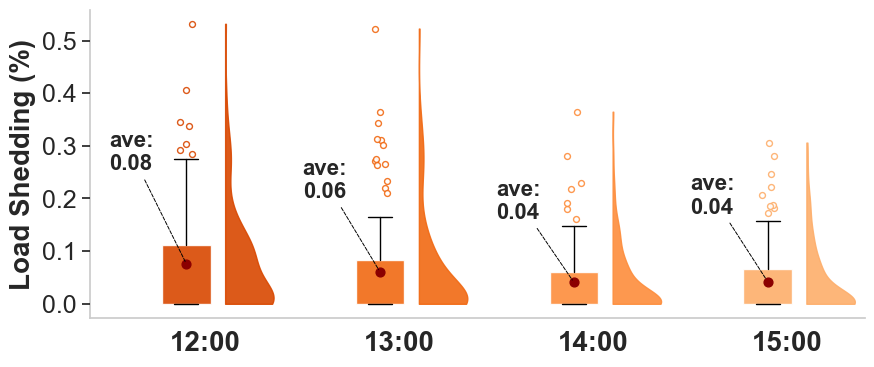

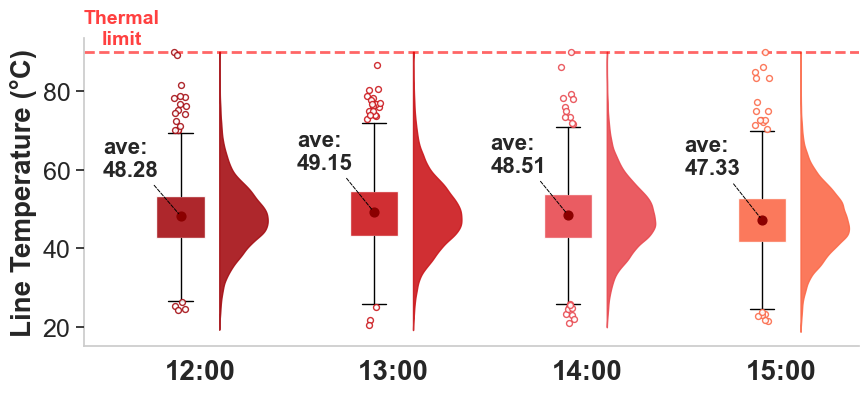

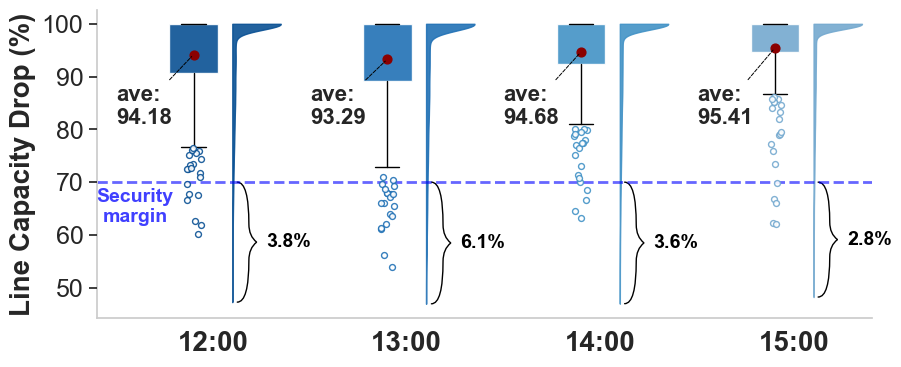

In [57]:
fut_hour_list = [12, 13, 14, 15]
fut_hour_labels = ['12:00', '13:00', '14:00', '15:00']

# Per-hour valid index (intersected)
vi_list = []
for hr in fut_hour_list:
    sub = df[(df['TDPF_solver'] == TDPF_solver)
             & (df['fut_heatwave_hour'] == hr)]
    vi_list.append((sub['solver_status'] == 1).values)
valid_index = np.logical_and.reduce(vi_list)

# --- Load shedding per hour ----------------------------------------------
ls_list = []
for hr in fut_hour_list:
    sub = df[(df['TDPF_solver'] == TDPF_solver)
             & (df['fut_heatwave_hour'] == hr)]
    ls_list.append(sub.loc[valid_index, 'node_load_shedding'].values.reshape(-1))

box_violin_plot(
    ls_list, fut_hour_labels, colors_orange[::-1], 'Load Shedding (%)',
    os.path.join(cur_dir, f'models/{country_code}/pics/hour_model_load_shedding_box_violin.pdf'),
)

# --- Line temperature and capacity drop per hour -------------------------
all_temp_list, all_capa_list = [], []
for hr in fut_hour_list:
    sub = df[(df['TDPF_solver'] == TDPF_solver)
             & (df['fut_heatwave_hour'] == hr)]
    temp_l, capa_l = [], []
    for fut_date in sub.loc[valid_index, 'fut_heatwave_date'].unique():
        sub2 = sub[sub['fut_heatwave_date'] == fut_date]
        ppc_path = cur_dir + f'/models/{country_code}/ppc/{fut_date}'
        for his_date in sub2['his_heatwave_date'].unique():
            his_fmt = datetime.strptime(
                his_date, '%Y-%m-%d'
            ).strftime('%Y-%m-%d %H:%M:%S')
            fname = build_result_id(
                country_code, n_bus, TDPF_solver, fut_date, his_fmt,
                storage_state, load_rate, thermal_limit,
            )
            res = np.load(
                os.path.join(ppc_path, fname), allow_pickle=True
            ).item()
            temp_l.append(res['con_temp'].max(1))
            capa_l.append(res['capacity_drop'])
    all_temp_list.append(np.concatenate(temp_l).reshape(-1))
    all_capa_list.append(np.concatenate(capa_l).reshape(-1) * 100)

box_violin_plot(
    all_temp_list, fut_hour_labels, colors_red[::-1], 'Line Temperature (°C)',
    os.path.join(cur_dir, f'models/{country_code}/pics/hour_model_line_temp_box_violin.pdf'),
    threshold=90, exceed_direction='above',
)
box_violin_plot(
    all_capa_list, fut_hour_labels, colors_blue[::-1], 'Line Capacity Drop (%)',
    os.path.join(cur_dir, f'models/{country_code}/pics/hour_model_capacity_drop_box_violin.pdf'),
    threshold=70, exceed_direction='below',
)

## 10. Load-Growth and Storage Sensitivity

Grouped bar plots showing how load shedding changes with annual load
growth rate (1–3 %) and battery storage state-of-charge (0–100 %).

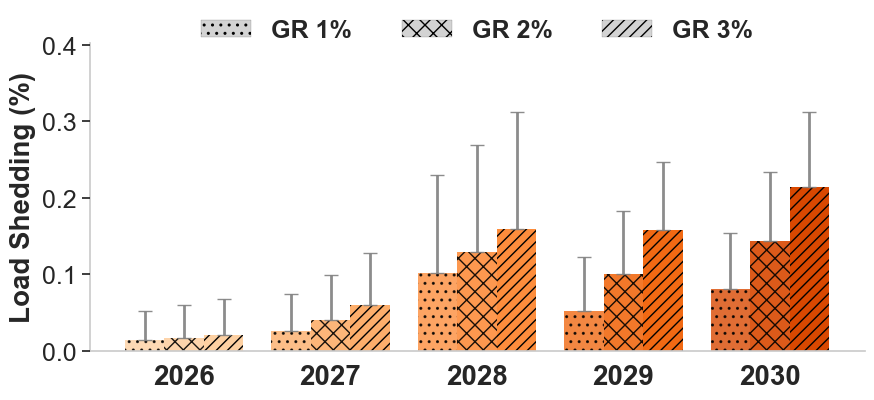

In [58]:
# --- Load-growth sensitivity ----------------------------------------------
TDPF_solver = 'td_seg_derate_iter_2'
growth_rates = [1.01, 1.02, 1.03]
scenario_labels = ['GR 1%', 'GR 2%', 'GR 3%']
fut_year_list = list(range(2026, 2031))

data_dict = {}
for rate, label in zip(growth_rates, scenario_labels):
    suffix = 'model_analysis' if rate == 1.01 else 'sensitivity_analysis'
    csv = build_csv_path(country_code, n_bus, storage_state,
                         rate, thermal_limit, suffix=suffix)
    df_g = pd.read_csv(csv)

    means, stds = [], []
    for yr in fut_year_list:
        sub = df_g[(df_g['TDPF_solver'] == TDPF_solver)
                   & (df_g['fut_heatwave_year'] == yr)]
        ls = sub.loc[sub['solver_status'] == 1, 'node_load_shedding'].values
        means.append(np.mean(ls))
        stds.append(np.std(ls))
    data_dict[label] = (np.array(means), np.array(stds))

grouped_bar_plot(
    data_dict, fut_year_list, scenario_labels, colors_orange,
    'Load Shedding (%)',
    cur_dir + f'/models/{country_code}/pics/load_sensitivity_grouped_bar.pdf',
)

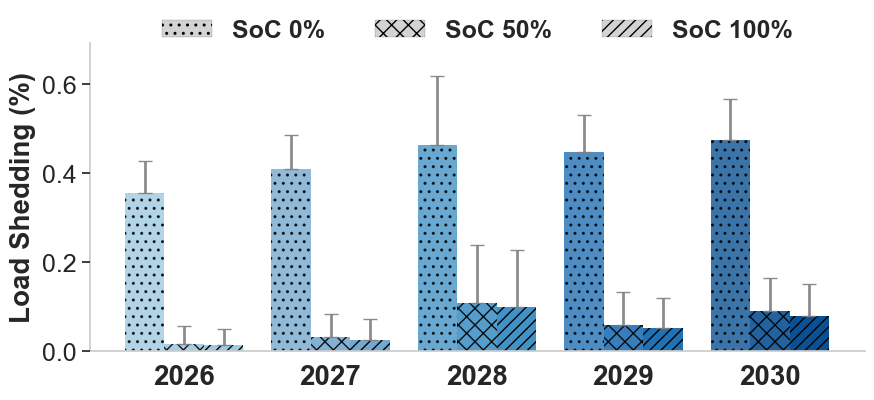

In [59]:
# --- Storage sensitivity --------------------------------------------------
growth_rates_fixed = 1.01
storage_states = [0.0, 0.5, 1.0]
scenario_labels = ['SoC 0%', 'SoC 50%', 'SoC 100%']

data_dict = {}
for state, label in zip(storage_states, scenario_labels):
    suffix = 'model_analysis' if state == 1.0 else 'sensitivity_analysis'
    csv = build_csv_path(country_code, n_bus, state,
                         growth_rates_fixed, thermal_limit, suffix=suffix)
    df_s = pd.read_csv(csv)

    means, stds = [], []
    for yr in fut_year_list:
        sub = df_s[(df_s['TDPF_solver'] == TDPF_solver)
                   & (df_s['fut_heatwave_year'] == yr)]
        ls = sub.loc[sub['solver_status'] == 1, 'node_load_shedding'].values
        means.append(np.mean(ls))
        stds.append(np.std(ls))
    data_dict[label] = (np.array(means), np.array(stds))

grouped_bar_plot(
    data_dict, fut_year_list, scenario_labels, colors_blue,
    'Load Shedding (%)',
    cur_dir + f'/models/{country_code}/pics/storage_sensitivity_grouped_bar.pdf',
)

## 11. Exploratory Scatter Plots

Relationships between air temperature, load demand, and load shedding
under the TD-OPF solver.

In [60]:
df = pd.read_csv(build_csv_path(
    country_code, n_bus, storage_state, load_rate, thermal_limit,
))
TDPF_solver = 'td_seg_derate_iter_2'
sub = df[df['TDPF_solver'] == TDPF_solver]
valid = sub['solver_status'] == 1
sub = sub[valid.values]

ls = sub['node_load_shedding'].values.reshape(-1)
temp = sub['air_temp'].values.reshape(-1)
load = sub['load'].values.reshape(-1)

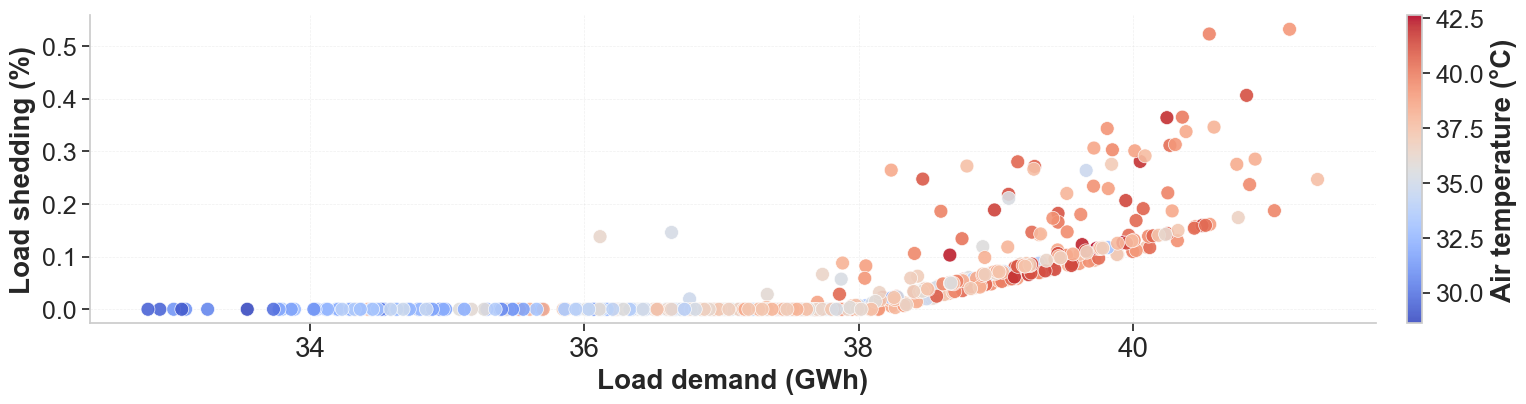

In [61]:
# --- Load vs load shedding (coloured by temperature) ---------------------
plt.rcParams.update(fig_config)
fig, ax = plt.subplots(figsize=[20, 4])
ax.set_axisbelow(True)
ax.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.3)

scatter = ax.scatter(
    load, ls, c=temp, cmap=plt.cm.coolwarm,
    alpha=0.9, s=100, edgecolors='white', linewidths=0.5,
)
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Load demand (GWh)', fontweight='bold')
ax.set_ylabel('Load shedding (%)', fontweight='bold')
cbar.set_label('Air temperature (°C)', fontweight='bold')
plt.tick_params(axis='both', which='both',
                top=False, right=False, left=True, bottom=True)

plt.savefig(
    os.path.join(cur_dir, f'models/{country_code}/pics/load_load_shedding_scatter.pdf'),
    bbox_inches='tight',
)

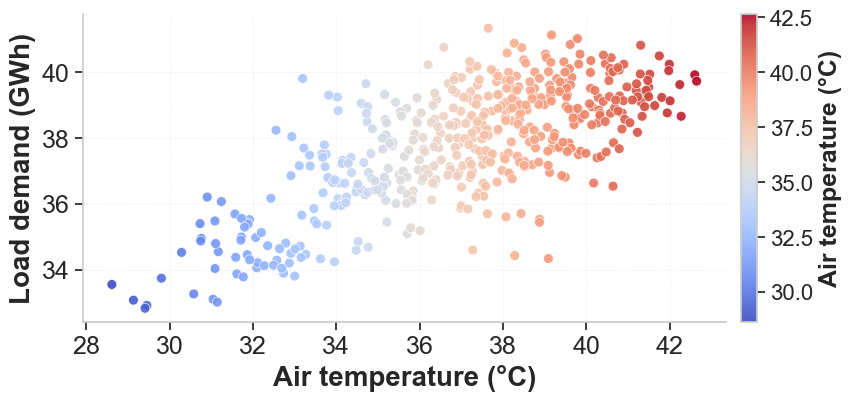

In [62]:
# --- Temperature vs load demand -------------------------------------------
fig, ax = plt.subplots(figsize=[10, 4])
ax.set_axisbelow(True)
ax.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.3)

scatter = ax.scatter(
    temp, load, c=temp, cmap=plt.cm.coolwarm,
    alpha=0.9, s=50, edgecolors='white', linewidths=0.5,
)
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Air temperature (°C)', fontweight='bold', fontsize=20)
ax.set_ylabel('Load demand (GWh)', fontweight='bold', fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar.set_label('Air temperature (°C)', fontweight='bold', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.tick_params(axis='both', which='both',
                top=False, right=False, left=True, bottom=True)

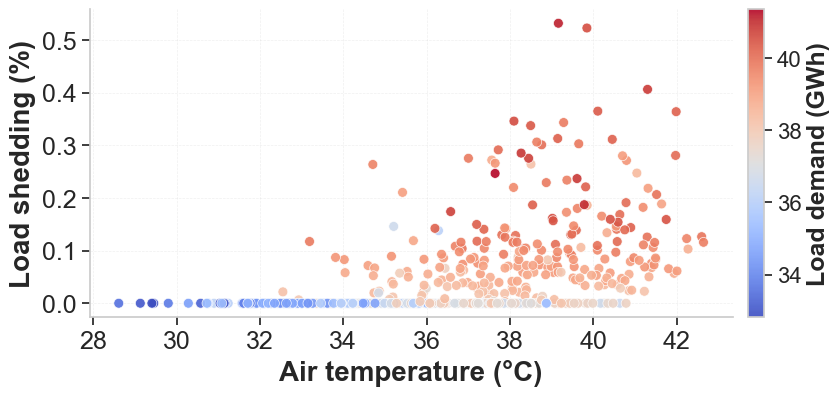

In [63]:
# --- Temperature vs load shedding (coloured by load) ---------------------
fig, ax = plt.subplots(figsize=[10, 4])
ax.set_axisbelow(True)
ax.grid(axis='both', linestyle='--', linewidth=0.5, alpha=0.3)

scatter = ax.scatter(
    temp, ls, c=load, cmap=plt.cm.coolwarm,
    alpha=0.9, s=50, edgecolors='white', linewidths=0.5,
)
cbar = plt.colorbar(scatter, ax=ax, pad=0.02)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Air temperature (°C)', fontweight='bold', fontsize=20)
ax.set_ylabel('Load shedding (%)', fontweight='bold', fontsize=20)
ax.tick_params(axis='both', labelsize=18)
cbar.set_label('Load demand (GWh)', fontweight='bold', fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.tick_params(axis='both', which='both',
                top=False, right=False, left=True, bottom=True)